In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from util import save_history, save_model, plot_metrics, plot_visualizations

In [3]:
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [4]:
model_version = 'v10.0'

In [5]:
with open('./data_schema.json', 'r') as f:
    config = json.load(f)
    
spectro_cols = config['spectro_cols']
photo_cols = config['photometry_cols']
generic_cols = config['generic_cols']
target_col = config['target_col']

In [6]:
df = pd.read_csv(f"./data/processed/spectrometry_photometry.csv")

X = df[spectro_cols + photo_cols + generic_cols]
y = df[target_col]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed_value)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
input_shape = X_train_scaled.shape[1]

optimizer = Adam(learning_rate=0.001)

inputs = keras.Input(shape=(input_shape,), name='Input')

# Layer 1
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64')(inputs)
x = layers.BatchNormalization(name='BN_64')(x)
x = layers.Activation('relu', name='Act_64')(x)
x = layers.Dropout(0.2, name='Dropout_64')(x)

# Layer 2
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128')(x)
x = layers.BatchNormalization(name='BN_128')(x)
x = layers.Activation('relu', name='Act_128')(x)
x = layers.Dropout(0.2, name='Dropout_128')(x)

# Layer 3
x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), name='Dense_256')(x)
x = layers.BatchNormalization(name='BN_256')(x)
x = layers.Activation('relu', name='Act_256')(x)
x = layers.Dropout(0.2, name='Dropout_256')(x)

# Layer 4
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128_2')(x)
x = layers.BatchNormalization(name='BN_128_2')(x)
x = layers.Activation('relu', name='Act_128_2')(x)
x = layers.Dropout(0.2, name='Dropout_128_2')(x)

# Output layer
outputs = layers.Dense(1, name='Output')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='Regression_Model')
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Use Huber loss to balance sensitivity to outliers
model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.Huber(), 
              metrics=['mae', 'mse', 'mape'])

model.summary()

Model: "Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 58)]              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                3776      
                                                                 
 BN_64 (BatchNormalization)  (None, 64)                256       
                                                                 
 Act_64 (Activation)         (None, 64)                0         
                                                                 
 Dropout_64 (Dropout)        (None, 64)                0         
                                                                 
 Dense_128 (Dense)           (None, 128)               8320      
                                                                 
 BN_128 (BatchNormalization)  (None, 128)         

In [10]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.5,
    epochs=1000,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/1000
2443/2443 [==============================] - 40s 16ms/step - loss: 1.1360 - mae: 1.1606 - mse: 4.4679 - mape: 10.9936 - val_loss: 0.3287 - val_mae: 0.3438 - val_mse: 0.2539 - val_mape: 3.4033
Epoch 2/1000
2443/2443 [==============================] - 50s 20ms/step - loss: 0.3979 - mae: 0.5881 - mse: 0.5537 - mape: 5.5934 - val_loss: 0.1285 - val_mae: 0.1929 - val_mse: 0.0929 - val_mape: 1.8946
Epoch 3/1000
2443/2443 [==============================] - 49s 20ms/step - loss: 0.2786 - mae: 0.5255 - mse: 0.4435 - mape: 5.0015 - val_loss: 0.0905 - val_mae: 0.1868 - val_mse: 0.0792 - val_mape: 1.8012
Epoch 4/1000
2443/2443 [==============================] - 50s 20ms/step - loss: 0.2339 - mae: 0.4865 - mse: 0.3836 - mape: 4.6331 - val_loss: 0.0696 - val_mae: 0.1455 - val_mse: 0.0522 - val_mape: 1.4304
Epoch 5/1000
2443/2443 [==============================] - 46s 19ms/step - loss: 0.1967 - mae: 0.4448 - mse: 0.3243 - mape: 4.2429 - val_loss: 0.0695 - val_mae: 0.1930 - val_mse: 0.074

In [11]:
model.save(f'./models/{model_version}/spec_photo_model.h5')

In [12]:
save_history(history, model_version)

In [13]:
y_pred_full = model.predict(X_test_scaled)

2094/2094 [==============================] - 4s 2ms/step


In [14]:
plot_metrics(y_test, y_pred_full)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.0897
Root Mean Squared Error (RMSE): 0.1720
R² Score: 0.9315


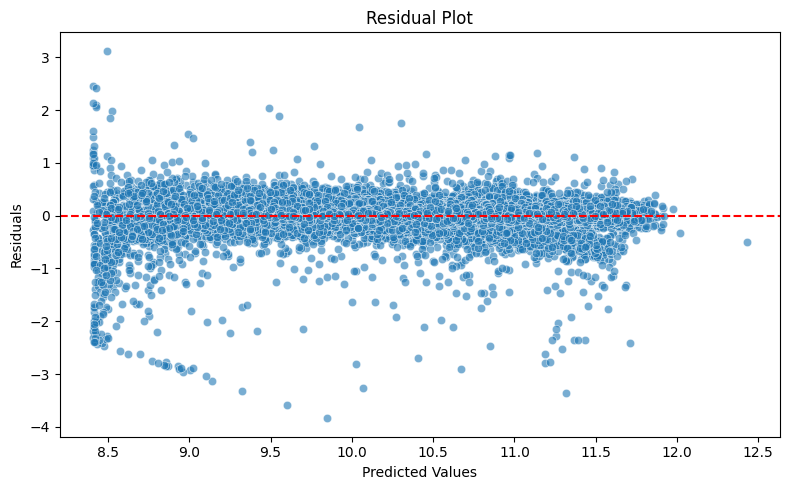

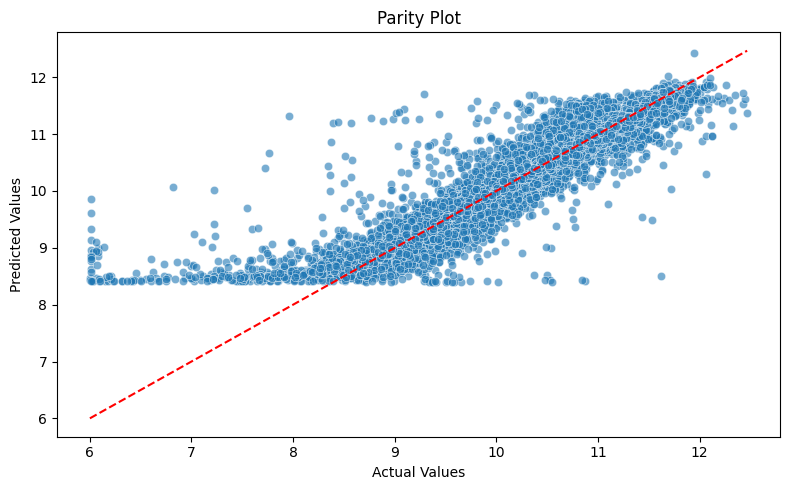

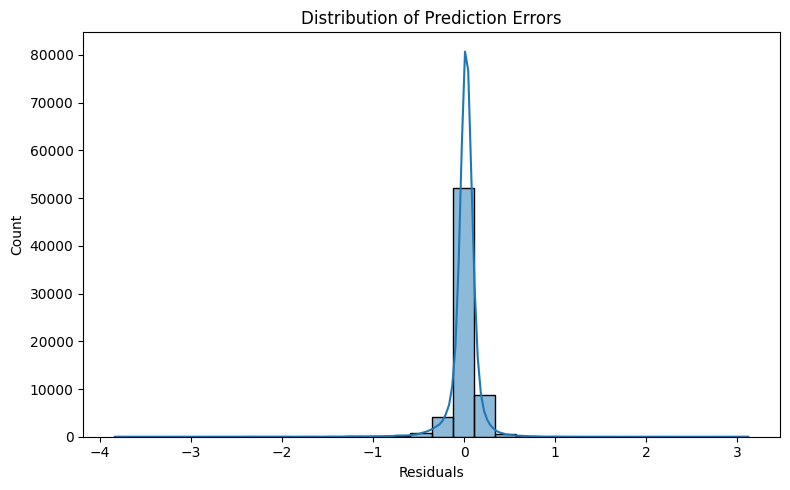

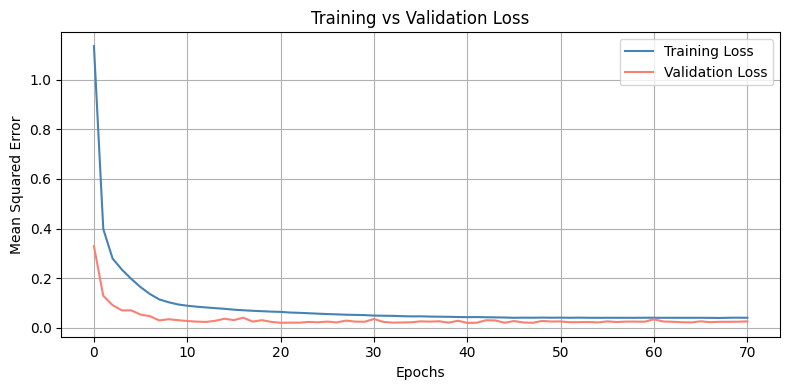

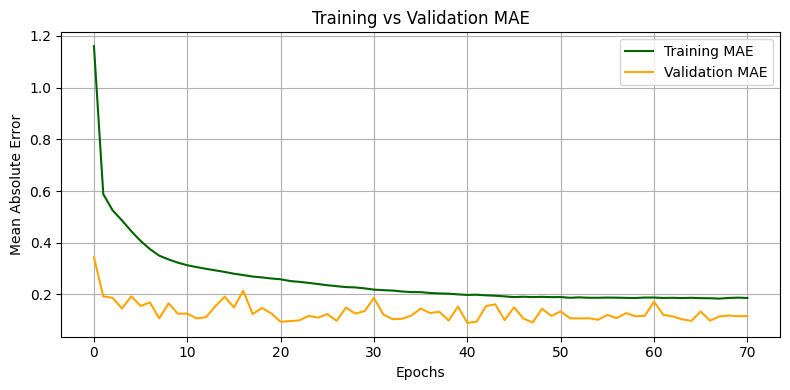

In [15]:
plot_visualizations(history, y_test, y_pred_full)